## RESNET

In [18]:
import sys
import os
sys.path.append("..")
from utils.train2 import *
device = 'cpu'

In [19]:
a = load_meta(os.path.join(os.pardir, 'metadata1'))

In [20]:
a.shape

(5902, 68)

In [21]:
class CustomRes(nn.Module):
    def __init__(self, n_features, n_classes, layers_list, activation=nn.ReLU(), dropout_list=None, batch_norm=True):
        super(CustomRes, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.layers_list = layers_list
        self.activation = activation
        self.dropout_list = dropout_list
        self.batch_norm = batch_norm
        self.net = []
        self.b_list = []
        if self.dropout_list:
            self.dropout_list = [nn.Dropout(i) for i in self.dropout_list]
        for i in range(len(self.layers_list)):
            if self.batch_norm:
                self.b_list.append(nn.BatchNorm1d(self.layers_list[i]))
            if i==0:
                self.net.append(nn.Linear(self.n_features, self.layers_list[i]))
            else:
                self.net.append(nn.Linear(self.layers_list[i-1]+3, self.layers_list[i]))
        self.last_layer = nn.Linear(self.layers_list[-1]+3, self.n_classes)
        self.net = nn.ModuleList(self.net)
        
    
    def forward(self, x):
        vp = torch.clone(x[:,-3:])   
        for i, l in enumerate(self.net):
            #print(i)
            if i==0:
                x = self.activation(l(x))
            else:
                x = self.activation(l(torch.cat((x, vp), dim=1)))
            if self.batch_norm:
                x = self.b_list[i](x)
            if self.dropout_list:
                x = (self.dropout_list[i])(x)
            
        x = self.last_layer(torch.cat((x, vp), dim=1))
        if self.n_classes == 1:
            x = torch.sigmoid(x)
   
        return x

    def eval(self):
        self.train(False)
        for i in self.b_list:
            i.train(False)
    def cust_train(self):
        self.train(True)
        for i in self.b_list:
            i.train(True)

In [22]:
mod = CustomRes(67, 788, [128, 128, 256, 256, 256], nn.GELU(), batch_norm=True)
print(mod)

CustomRes(
  (activation): GELU()
  (last_layer): Linear(in_features=259, out_features=788, bias=True)
  (net): ModuleList(
    (0): Linear(in_features=67, out_features=128, bias=True)
    (1): Linear(in_features=131, out_features=128, bias=True)
    (2): Linear(in_features=131, out_features=256, bias=True)
    (3): Linear(in_features=259, out_features=256, bias=True)
    (4): Linear(in_features=259, out_features=256, bias=True)
  )
)


In [ ]:
eo = train(a, mod, ep=100, save=True, prefix="res_met_1_static")


C:\Users\LENOVO\.conda\envs\paltas\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
E:\belugas_classification\notebooks\..\utils\train2.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vec_train = np.array([train_ids for train_ids,_ in skf.split(data, data.iloc[:,-1])])
C:\Users\LENOVO\.conda\envs\paltas\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
E:\belugas_classification\notebooks\..\utils\train2.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tupl

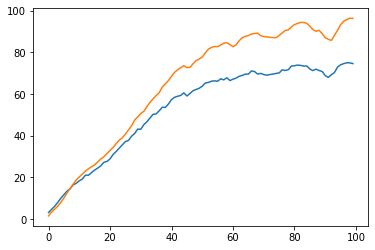

In [17]:
plt.plot(eo['acc'])
plt.plot(eo['train_acc'])